## Data Exploration

In [ ]:

s3_data ="s3://aegovan-data/human_output/human_interactions_ppi_v2.json"
s3_annotations ="s3://aegovan-data/processed_dataset/input_data_pubtator_annotated_human.txt"
s3_results_prefix = "s3://aegovan-data/processed_dataset/"
human_idmapping_dat = "/users/aeg/Downloads/HUMAN_9606_idmapping.dat"
idmapping_dat="./tmpmap.dat"

In [2]:
!cp $human_idmapping_dat $idmapping_dat
!cat $mouse_idmapping_dat >> $idmapping_dat
!wc -l $idmapping_dat

/bin/sh: $idmapping_dat: ambiguous redirect
 6050174 ./tmpmap.dat


In [3]:
import logging, sys

# Set up logging
logging.basicConfig(level=logging.getLevelName("INFO"), handlers=[logging.StreamHandler(sys.stdout)],
                        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')


In [4]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


In [5]:
data_file="input_data.json"
annotations_file="input_data_annotations.txt"

In [6]:
download_single_file(s3_data, data_file)

2021-01-02 21:00:37,580 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


In [7]:
download_single_file(s3_annotations, annotations_file)

In [8]:

import pandas as pd

data = pd.read_json(data_file)

print("Total number of records: {}".format(data.shape[0]))

Total number of records: 3381


In [9]:
data.pubmedId.nunique()

850

In [10]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Times']
plt.rcParams.update({'font.size': 12})

## Preliminary data transformations

In [11]:
#TODO: Fix data format
data["pubmedId"] = data["pubmedId"].astype(str)
data["interactionId"] = data["interactionId"].astype(str)
data["isValid"] =  data.isNegative.isin(['false', '0', 'False'])
data = data.drop('isNegative', axis=1)

### Sneak preview of the data

In [12]:
data.head(n=3)

,interactionId,interactionType,participants,pubmedId,pubmedTitle,pubmedabstract,isValid
0,1585513,phosphorylation,"[{'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}, {'uniprotid': 'O43293-2', 'alias': [['o43293-2'], ['Death-associated protein kinase 3'], ['ZIPK-S'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True
1,1585516,phosphorylation,"[{'uniprotid': 'O43293-1', 'alias': [['o43293-1'], ['Death-associated protein kinase 3'], ['ZIPK-L'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}, {'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True
10,575312,phosphorylation,"[{'uniprotid': 'P02686-1', 'alias': [['p02686-1'], ['Myelin basic protein'], ['MBP'], ['Myelin A1 protein'], ['Myelin membrane encephalitogenic protein'], ['Golli-MBP1'], ['HOG7']], 'alternative_uniprots': []}, {'uniprotid': 'Q8I629', 'alias': [['q8i629_plaf7'], ['PF3D7_1201600']], 'alternative_uniprot

In [13]:
data.shape

(3381, 7)

In [14]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

### Number of interactions per paper
**Note: The number of interactions per paper only takes the filtered interactions extracted from the Intact database**

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


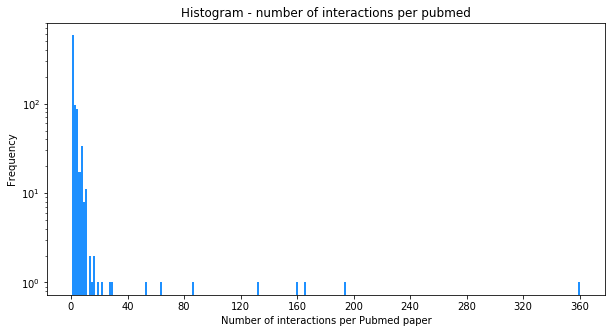

In [15]:
import matplotlib.pyplot as plt
import numpy as np 

ax = plt.axes( yscale='log')
ax.xaxis.set_major_locator(plt.MaxNLocator(10, prune='lower'))

#sns.distplot(data.pubmedId.value_counts().tolist(), bins=100, kde=False, norm_hist=True)

data.pubmedId.value_counts().plot.hist (bins=250,figsize=(10,5), ax=ax, color='dodgerblue')
plt.title('Histogram - number of interactions per pubmed')
plt.xlabel('Number of interactions per Pubmed paper')
plt.ylabel('Frequency')
#plt.show()
plt.savefig('PaperVsInteractions.eps', bbox_inches='tight')
plt.savefig('PaperVsInteractions.png', bbox_inches='tight')
plt.show()

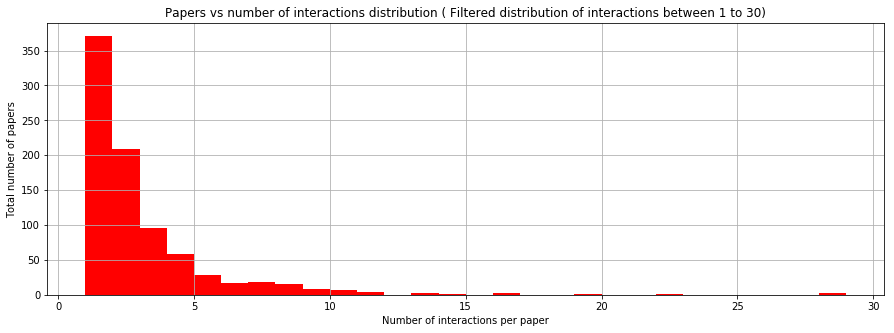

In [16]:
df = data.pubmedId.value_counts().hist (bins=range(1, 30), figsize=(15,5), color = 'red')

plt.title('Papers vs number of interactions distribution ( Filtered distribution of interactions between 1 to 30)')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of papers')

plt.show()

### Interaction Types distribution

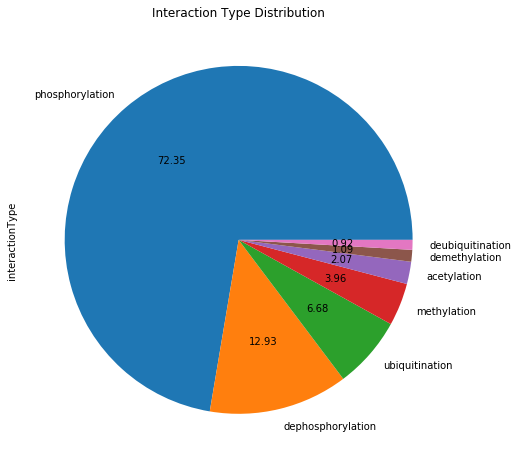

In [17]:
data.interactionType.value_counts().plot.pie(autopct='%.2f',figsize=(8, 8))
plt.title('Interaction Type Distribution')
plt.savefig("Interactiontype.svg")
plt.show()

In [18]:
data.interactionType.value_counts().to_frame()

,interactionType
phosphorylation,2446
dephosphorylation,437
ubiquitination,226
methylation,134
acetylation,70
demethylation,37
deubiquitination,31


### Distinct interaction types per paper

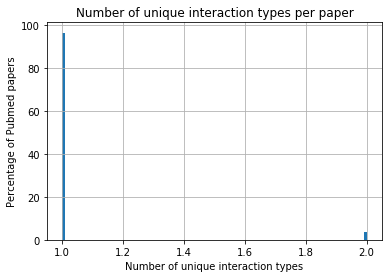

In [19]:
import numpy as np

distinct_no_papers = data['pubmedId'].nunique()

data.groupby('pubmedId')['interactionType'].nunique().hist(bins=100, density=1)
plt.title("Number of unique interaction types per paper")
plt.xlabel('Number of unique interaction types')
plt.ylabel('Percentage of Pubmed papers'.format(distinct_no_papers))
plt.show()


### Postive vs Negative Relationships

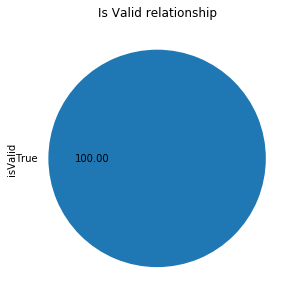

In [20]:
data.isValid.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Is Valid relationship')
plt.show()

### Number of participants per interaction

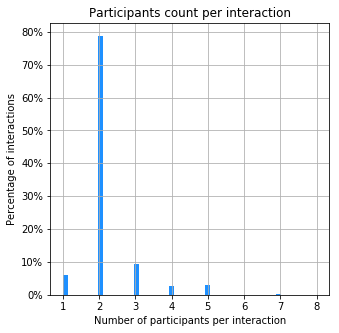

In [21]:
import numpy as np
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,1, figsize=(15,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())

data['participants_count'] = data["participants"].apply(lambda x: len(x))

data['participants_count'].hist (bins=50, ax=c_ax, figsize=(5,5), color = 'dodgerblue',  weights = np.ones_like(data['participants_count'].index)*100 / len(data['participants_count'].index))
plt.title("Participants count per interaction")
plt.xlabel('Number of participants per interaction')
plt.ylabel('Percentage of interactions')
plt.savefig("ParticipantsPerInteraction.eps")
plt.show()

### Explore if the abstract contains the trigger word

In [22]:
!pip install nltk==3.4.5

You should consider upgrading via the 'pip install --upgrade pip' command.


In [23]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

stemmer = PorterStemmer()
print(pd.DataFrame(data.interactionType.unique()).apply(lambda r: stemmer.stem(r.iloc[0].lower()), axis=1))

data["hasTriggerWord"] = data.apply(lambda r: stemmer.stem(r["interactionType"].lower()) in r["pubmedabstract"].lower() , 1)

0      phosphoryl
1     deubiquitin
2          methyl
3        demethyl
4          acetyl
5       ubiquitin
6    dephosphoryl
dtype: object


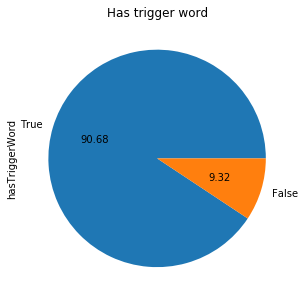

In [24]:
data.hasTriggerWord.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has trigger word')
plt.show()

In [25]:
data.groupby([ 'interactionType','hasTriggerWord']).size().unstack().apply(lambda x: round(x/sum(x),3)*100, axis=1)


hasTriggerWord,False,True
interactionType,,
acetylation,7.1,92.9
demethylation,2.7,97.3
dephosphorylation,11.4,88.6
deubiquitination,22.6,77.4
methylation,0.7,99.3
phosphorylation,10.1,89.9
ubiquitination,1.8,98.2


### Explore how many of the entity alias are mentioned in the abstract

In [26]:
%%time 

from difflib import SequenceMatcher
def getEntityMentionsCount(r):
    count = 0
    abstract = r["pubmedabstract"].lower()
    abstract_len= len(abstract)
    for p in r["participants"]:
        if p is None or p['alias'] is None : continue
        
        for a in p['alias']:
            alias = a[0].lower()
            s = SequenceMatcher(None, abstract, alias)
            _,_,match_size = s.find_longest_match(0, len(abstract), 0, len(alias))
            if match_size >= 3 and match_size >= len(alias)/2 :
                count += 1
        
    return count
        

data["entityMentionsCount"] = data.apply(lambda r: getEntityMentionsCount(r)  , 1)

CPU times: user 27 s, sys: 210 ms, total: 27.2 s
Wall time: 28.2 s


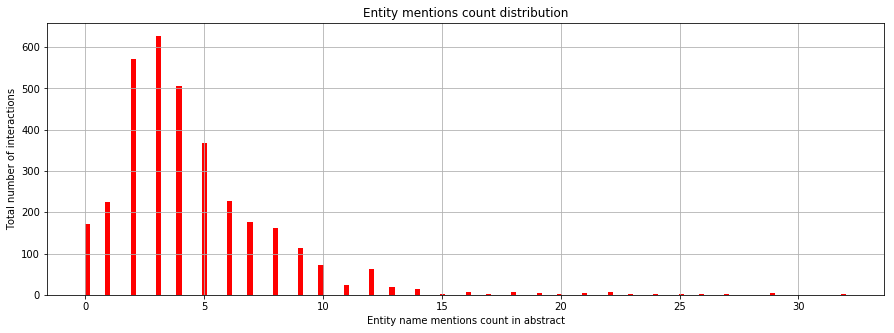

In [27]:
data['entityMentionsCount'].hist ( bins=150, figsize=(15,5), color = 'red')
plt.title('Entity mentions count distribution')
plt.xlabel('Entity name mentions count in abstract')
plt.ylabel('Total number of interactions')

plt.show()

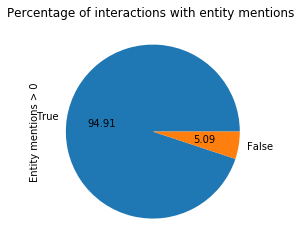

In [28]:
(data['entityMentionsCount'] > 0).value_counts().plot.pie(autopct='%.2f')
plt.title("Percentage of interactions with entity mentions ")
plt.ylabel("Entity mentions > 0")
plt.show()

### Randomly eye ball interactions with no entity mentions

In [29]:

data.query('entityMentionsCount == 0')[['participants','pubmedabstract' ]].sample(n=3)


,participants,pubmedabstract
798,"[{'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}, {'uniprotid': 'P98175-1', 'alias': [['p98175-1'], ['RNA-binding protein 10'], ['RBM10'], ['DXS8237E'], ['GPATC9'], ['GPATCH9'], ['KIAA0122'], ['G patch domain-containing protein 9'], ['RNA-binding motif protein 10'], ['RNA-binding protein S1-1']], 'alternative_uniprots': []}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."
827,"[{'uniprotid': 'Q9BW71-1', 'alias': [['q9bw71-1'], ['HIRA-interacting protein 3'], ['HIRIP3']], 'alternative_uniprots': []}, {'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."
801,"[{'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}, {'uniprotid': 'Q6UN15-1', 'alias': [['q6un15-1'], [""Pre-mRNA 3'-end-processing factor FIP1""], ['FIP1L1'], ['FIP1'], ['RHE'], ['FIP1-like 1 protein'], ['Factor interacting with PAP'], ['Rearranged in hypereosinophilia']], 'alternative_uniprots': []}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."


In [30]:
data.head(n=2)

,interactionId,interactionType,participants,pubmedId,pubmedTitle,pubmedabstract,isValid,participants_count,hasTriggerWord,entityMentionsCount
0,1585513,phosphorylation,"[{'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}, {'uniprotid': 'O43293-2', 'alias': [['o43293-2'], ['Death-associated protein kinase 3'], ['ZIPK-S'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,2,True,9
1,1585516,phosphorylation,"[{'uniprotid': 'O43293-1', 'alias': [['o43293-1'], ['Death-associated protein kinase 3'], ['ZIPK-L'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}, {'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,2,True,9


## Data Transformation

### Filter interactions with more than 2 participants

In [31]:
filtered = data.query('participants_count <= 2')
filtered.shape

(2868, 10)

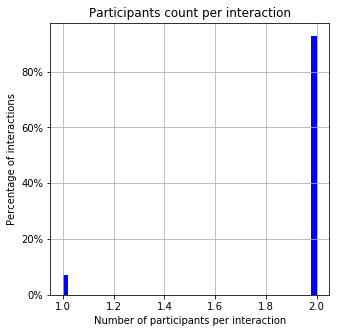

In [32]:
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,1, figsize=(15,5))



c_ax= ax
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
filtered['participants_count'].hist (bins=50, figsize=(5,5), ax=c_ax, color = 'blue',  weights = np.ones_like(filtered['participants_count'].index)*100 / len(filtered['participants_count'].index))
plt.title("Participants count per interaction")
plt.xlabel('Number of participants per interaction')
plt.ylabel('Percentage of interactions')
plt.savefig("ParticipantsPerInteraction.eps")
plt.show()

### Filter out interactions from paper with more than 15 interactions

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


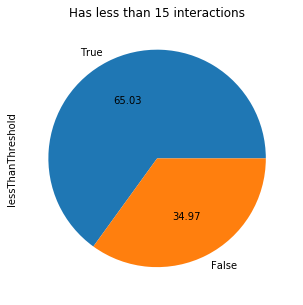

In [33]:
pubmed_interaction_count = filtered.pubmedId.value_counts().to_frame().rename(columns={"pubmedId":"interactionCountPerPubmed"})


#interactions_count= pd.DataFrame()
filtered["lessThanThreshold"] = filtered.apply(lambda r: r["pubmedId"] in  pubmed_interaction_count.query('interactionCountPerPubmed <= 15').index , 1)


filtered.lessThanThreshold.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has less than 15 interactions')
plt.show()

In [34]:
filtered = filtered.query("lessThanThreshold == 1")

In [35]:
print("Total number of records after filter: {}".format(filtered.shape[0]))

Total number of records after filter: 1865


###  Flatten partcipants into participant 1 and particpiant 2

In [36]:
from datatransformer.jsonPPIFlattenTransformer import IntactJsonPpiFlattenTransformer
 

sut = IntactJsonPpiFlattenTransformer()

data_transformed = sut.transform(filtered)


In [37]:
data_transformed.head(n=2)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract
0,9,True,1585513,phosphorylation,True,True,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,"[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-2,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."
1,9,True,1585516,phosphorylation,True,True,"[[o43293-1], [Death-associated protein kinase 3], [ZIPK-L], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-1,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."


In [38]:
data_transformed.shape

(1865, 14)

### Remove records where the participantId is null

In [39]:
data_transformed.shape

(1865, 14)

In [40]:
data_filtered = data_transformed[data_transformed.participant1Id.notnull()]
data_filtered.shape

(1795, 14)

In [41]:
data_filtered = data_filtered[data_filtered.participant2Id.notnull()]
data_filtered.shape

(1766, 14)

In [42]:
data_filtered.head(n=2)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract
0,9,True,1585513,phosphorylation,True,True,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,"[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-2,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."
1,9,True,1585516,phosphorylation,True,True,"[[o43293-1], [Death-associated protein kinase 3], [ZIPK-L], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-1,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."


### Normalise abstract

In [43]:

def normalise_absract(data, enity_annotations_file):
    from datatransformer.abstractGeneNormaliser import AbstractGeneNormaliser
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper
    from datatransformer.ncbiGeneUniprotMapper import NcbiGeneUniprotMapper


    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader
    from datatransformer.textGeneNormaliser import TextGeneNormaliser


    import os
    
 
    localdb = idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
        
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))
        
        
        # 
        normaliser = AbstractGeneNormaliser(annotations_json)
        normaliser.text_gene_normaliser = TextGeneNormaliser(geneIdConverter = mapper) 
        result = normaliser.transform(data)
        
       

        return result

In [44]:
%%time

data_filtered = normalise_absract(data_filtered, annotations_file)

2021-01-02 21:02:38,139 - datatransformer.abstractGeneNormaliser - INFO - Starting transformation..
2021-01-02 21:02:42,411 - datatransformer.abstractGeneNormaliser - INFO - Completed normalised abstract...
2021-01-02 21:02:42,412 - datatransformer.abstractGeneNormaliser - INFO - Adding annotations ...
2021-01-02 21:02:42,538 - datatransformer.abstractGeneNormaliser - INFO - Adding annotations_abstract...
2021-01-02 21:02:42,564 - datatransformer.abstractGeneNormaliser - INFO - Adding num_unique_gene_normalised_id...
2021-01-02 21:02:42,590 - datatransformer.abstractGeneNormaliser - INFO - Adding num_gene_normalised_id...
2021-01-02 21:02:42,604 - datatransformer.abstractGeneNormaliser - INFO - Gene Id links...
2021-01-02 21:02:42,634 - datatransformer.abstractGeneNormaliser - INFO - Completed transformation
CPU times: user 4.28 s, sys: 132 ms, total: 4.41 s
Wall time: 4.6 s


In [45]:
data_filtered.shape

(1766, 20)

In [46]:
data_filtered.head(n=3)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,gene_to_uniprot_map
0,9,True,1585513,phosphorylation,True,True,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,"[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-2,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.","O43293 (O43293) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that O43293 also plays a role in regulating Q7Z406 phosphorylation. Here, we found novel O43293 isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to O14974(O14974) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to Q7Z406. These results indicate that a leucine zipper is not critical for the binding of O43293 to O14974 and Q7Z406. Consistently, hZIPK-S localized with stress-fibers where they co-localized with Q7Z406. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to O14974, while the Q7Z406 binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of Q7Z406 phosphorylation.","[{'start': '0', 'end': '33', 'name': 'Zipper-interacting protein kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '35', 'end': '45', 'name': 'ZIP kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '197', 'end': '207', 'name': 'ZIP kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '240', 'end': '246', 'name': 'myosin', 'type': 'Gene', 'normalised_id': '79784'}, {'start': '285', 'end': '295', 'name': 'ZIP kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '416', 'end': '454', 'name': 'myosin phosphatase targeting subunit 1', 'type': 'Gene', 'normalised_id': '4659'}, {'start': '455', 'end': '460', 'name': 'MYPT1', 'type': 'Gene', 'normalised_id': '4659'}, {'start': '563', 'end': '569', 'name': 'myosin', 'type': 'Gene', 'normalised_id': '79784'}, {'start': '651', 'end': '661', 'name': 'ZIP kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '665', 'end': '670', 'name': 'MYPT1', 'type': 'Gene', 'normalised_id': '4659'}, {

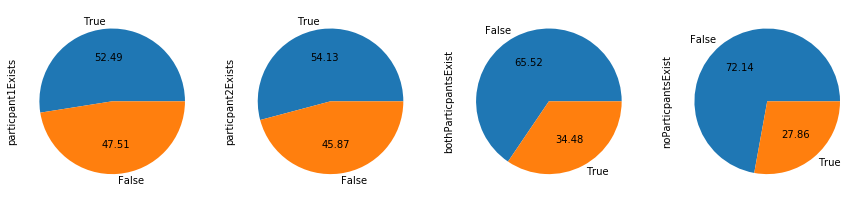

In [47]:

fig, ax =  plt.subplots( 1,4, figsize=(15,5))

tmp = pd.DataFrame()

data_filtered["particpant1Exists"] = data_filtered.apply(lambda r: r["participant1Id"] in r["normalised_abstract"]   , 1)
data_filtered["particpant1Exists"].value_counts().plot.pie(ax=ax[0], autopct='%.2f')

data_filtered["particpant2Exists"] = data_filtered.apply(lambda r: r["participant2Id"] in r["normalised_abstract"]   , 1)
data_filtered["particpant2Exists"].value_counts().plot.pie(ax=ax[1], autopct='%.2f')


data_filtered["bothParticpantsExist"] = data_filtered.apply(lambda r: r["particpant2Exists"] and r["particpant1Exists"]   , 1)
data_filtered["bothParticpantsExist"].value_counts().plot.pie(ax=ax[2], autopct='%.2f')

data_filtered["noParticpantsExist"] = data_filtered.apply(lambda r: not (r["particpant2Exists"] or r["particpant1Exists"])   , 1)
data_filtered["noParticpantsExist"].value_counts().plot.pie(ax=ax[3], autopct='%.2f')


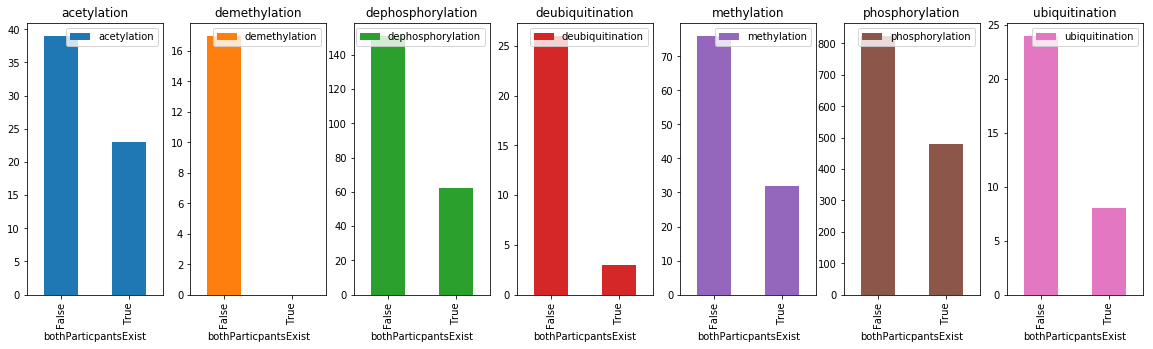

In [48]:
fig, ax = plt.subplots(1,7, figsize=(20,5))

data_filtered.groupby([ "bothParticpantsExist", 'interactionType']).size().unstack().plot.bar(subplots=True, ax=ax)
plt.show()

In [49]:
data_filtered.query("particpant2Exists == False").sample(4)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,gene_to_uniprot_map,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist
243,3,True,2653494,phosphorylation,True,True,"[[bax_human], [Apoptosis regulator BAX], [BAX], [BCL2L4], [Bcl-2-like protein 4]]",Q07812,"[[gsk3b_human], [Glycogen synthase kinase-3 beta], [GSK3B], [Serine/threonine-protein kinase GSK3B]]",P49841,2,20080742,Activation of mitochondrial ERK protects cancer cells from death through inhibition of the permeability transition.,"We studied human cancer cell models in which we detected constitutive activation of ERK. A fraction of active ERK was found to be located in mitochondria in RWPE-2 cells, obtained by v-Ki-Ras transformation of the epithelial prostate RWPE-1 cell line; in metastatic prostate cancer DU145 cells; and in osteosarcoma SAOS-2 cells. All these tumor cells displayed marked resistance to death caused by apoptotic stimuli like arachidonic acid and the BH3 mimetic EM20-25, which cause cell death through the mitochondrial permeability transition pore (PTP). PTP desensitization and the ensuing resistance to cell death induced by arachidonic acid or EM20-25 could be ablated by inhibiting ERK with the drug PD98059 or with a selective ERK activation inhibitor peptide. ERK inhibition enhanced glycogen synthase kinase-3 (GSK-3)-dependent phosphorylation of the pore regulator cyclophilin D, whereas GSK-3 inhibition protected from PTP opening. Neither active ERK in mitochondria nor pore desensitization was observed in non-transformed RWPE-1 cells. Thus, in tumor cells mitochondrial ERK activation desensitizes the PTP through a signaling axis that involves GSK-3 and cyclophilin D, a finding that provides a mechanistic basis for increased resistance to apoptosis of neoplastic cells.","We studied human cancer cell models in which we detected constitutive activation of P28482. A fraction of active P28482 was found to be located in mitochondria in RWPE-2 cells, obtained by v-Ki-Ras transformation of the epithelial prostate RWPE-1 cell line; in metastatic prostate cancer DU145 cells; and in osteosarcoma SAOS-2 cells. All these tumor cells displayed marked resistance to death caused by apoptotic stimuli like arachidonic acid and the BH3 mimetic EM20-25, which cause cell death through the mitochondrial permeability transition pore (PTP). PTP desensitization and the ensuing resistance to cell death induced by arachidonic acid or EM20-25 could be ablated by inhibiting P28482 with the drug PD98059 or with a selective P28482 activation inhibitor peptide. P28482 inhibition enhanced glycogen synthase kinase-3 (GSK-3)-dependent phosphorylation of the pore regulator Q08752, whereas GSK-3 inhibition protected from PTP opening. Neither active P28482 in mitochondria nor pore desensitization was observed in non-transformed RWPE-1 cells. Thus, in tumor cells mitochondrial P28482 activation desensitizes the PTP through a signaling axis that involves GSK-3 and Q08752, a finding that provides a mechanistic basis for increased resistance to apoptosis of neoplastic cells.","[{'start': '11', 'end': '16', 'name': 'human', 'type': 'Species', 'normalised_id': '9606'}, {'start': '84', 'end': '87', 'name': 'ERK', 'type': 'Gene', 'normalised_id': '5594'}, {'start': '110', 'end': '113', 'name': 'ERK', 'type': 'Gene', 'normalised_id': '5594'}, {'start': '157', 'end': '163', 'name': 'RWPE-2', 'type': 'Species', 'normalised_id': '9606'}, {'start': '234', 'end': '240', 'name': 'RWPE-1', 'type': 'Species', 'normalised_id': '9606'}, {'start': '282', 'end': '287', 'name': 'DU145', 'type': 'Species', 'normalised_id': '9606'}, {'start': '315', 'end': '321', 'name': 'SAOS-2', 'type': 'Species', 'normalised_id': '960

### Remove abstracts where both participants do not exists

In [50]:
data_filtered =  data_filtered.query('particpant2Exists == True')
data_filtered.shape

(956, 24)

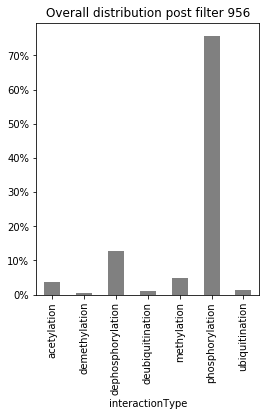

In [51]:
fig, ax = plt.subplots( 1,1, figsize=(4,5))

c_ax= ax
c_ax.set_title('Overall distribution post filter {}'.format(data_filtered.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))

data_filtered.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(data_filtered.interactionType))).plot.bar(ax=c_ax, color='gray')


plt.savefig("Interactiontype_postfilter.eps", bbox_inches='tight')
plt.savefig("Interactiontype_postfilter.png", bbox_inches='tight')


plt.show()

#### Check how many contain the trigger word

In [52]:
data_filtered.groupby([ 'interactionType','hasTriggerWord']).size().unstack(fill_value = 0)

hasTriggerWord,False,True
interactionType,,
acetylation,3,33
demethylation,0,5
dephosphorylation,23,98
deubiquitination,1,10
methylation,0,47
phosphorylation,70,654
ubiquitination,0,12


In [53]:
data_filtered.groupby([ 'interactionType','hasTriggerWord']).size().unstack(fill_value = 0).apply(lambda x: round(x/sum(x),3)*100, axis=1)


hasTriggerWord,False,True
interactionType,,
acetylation,8.3,91.7
demethylation,0.0,100.0
dephosphorylation,19.0,81.0
deubiquitination,9.1,90.9
methylation,0.0,100.0
phosphorylation,9.7,90.3
ubiquitination,0.0,100.0


In [54]:
data_filtered.query('pubmedId == "17126281"')

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,gene_to_uniprot_map,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist


### Split Train/Test/validation

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

unique_pubmed = data_filtered.pubmedId.unique()
stratified =  [ data_filtered.query("pubmedId == '{}'".format(p))['interactionType'].iloc[0] for p in unique_pubmed]
trainpubmed, valpubmed  = train_test_split(unique_pubmed,  test_size=.1,
                                                        random_state=777, stratify=stratified)


stratified =  [data_filtered.query("pubmedId == '{}'".format(p))['interactionType'].iloc[0] for p in trainpubmed]
trainpubmed, testpubmed = train_test_split(trainpubmed,  test_size=.2,
                                                        random_state=777, stratify=stratified)

In [56]:
data_filtered.query("interactionType == 'demethylation'")['pubmedId'].unique()

array(['17320160', '17805299', '17567753'], dtype=object)

In [57]:
data_filtered.query("interactionType == 'ubiquitination'")['pubmedId'].unique()

array(['15103385', '16213503', '15710384', '14603323', '12878161',
       '12230472', '11588219', '11894096', '11882901', '19656744',
       '16601676', '11027293'], dtype=object)

In [58]:
train = data_filtered[data_filtered['pubmedId'].isin(trainpubmed)]
test = data_filtered[data_filtered['pubmedId'].isin(testpubmed)]
val = data_filtered[data_filtered['pubmedId'].isin(valpubmed)]




In [59]:
train.query("interactionType == 'ubiquitination'")['pubmedId'].unique()

array(['15103385', '16213503', '15710384', '12230472', '11588219',
       '11882901', '19656744', '16601676', '11027293'], dtype=object)

In [60]:
val.query("interactionType == 'ubiquitination'")


,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,gene_to_uniprot_map,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist
1097,7,True,372889,ubiquitination,True,True,"[[q9c035-4], [Tripartite motif-containing protein 5], [RING-type E3 ubiquitin transferase TRIM5], [TRIM5], [RNF88], [RING finger protein 88]]",Q9C035-4,"[[ub2d2_human], [Ubiquitin-conjugating enzyme E2 D2], [(E3-independent) E2 ubiquitin-conjugating enzyme D2], [E2 ubiquitin-conjugating enzyme D2], [UBC5B], [UBCH4], [UBE2D2], [UBC4], [UBCH5B], [Ubiquitin-protein ligase D2], [Ubiquitin carrier protein D2], [Ubiquitin-conjugating enzyme E2-17 kDa 2], [Ubiquitin-conjugating enzyme E2(17)KB 2], [PUBC1], [p53-regulated ubiquitin-conjugating enzyme 1]]",P62837,2,12878161,None,"We previously identified BTBD1 and BTBD2 as novel topoisomerase I-interacting proteins that share 80% amino acid identity. Here we report the characterization of their subcellular localization. In a number of mouse and human cells, BTBD1 and BTBD2 (BTBD1/2) colocalized to punctate or elongated cytoplasmic bodies (< 5 microm long and several per cell) that were larger and more elongated in cancer cell lines than in fibroblasts and myoblasts. A search for potential colocalizing proteins identified TRIM family members that localize to morphologically similar cytoplasmic bodies, which were then tested for colocalization with BTBD1/2. TRIM5delta, expressed as a GFP fusion, colocalized with BTBD1/2 immunostaining and appeared to serve as a scaffold for the assembly of endogenous BTBD1/2 proteins. TRIM family members contain a RING domain, B-box(es), and coiled-coil regions, which have a characteristic order and spacing (RBCC domain). RING-dependent ubiquitin ligase activity and multimerization via the coiled-coil region may be defining properties of the RBCC/TRIM protein family. We found that TRIM5delta with a deleted coiled-coil region or a mutated RING domain failed to colocalize with BTBD1/2. Additionally, TRIM5delta ubiquitylated itself in a RING finger- and UbcH5B-dependent manner. BTBD1/2 each contain a PHR-similarity region, repeated twice on the putative ubiquitin ligases PAM, highwire and RPM-1, which also contain a RING and B-box. Thus, four protein modules found on each of these putative ubiquitin ligases, a RING, a B-box and two PHR repeats, are present on BTBD1/2 and TRIM5delta that are colocalized to cytoplasmic bodies.","We previously identified Q9H0C5 and Q8IY92 as novel topoisomerase I-interacting proteins that share 80% amino acid identity. Here we report the characterization of their subcellular localization. In a number of mouse and human cells, Q9H0C5 and Q8IY92 (84464;53339;55643) colocalized to punctate or elongated cytoplasmic bodies (< 5 microm long and several per cell) that were larger and more elongated in cancer cell lines than in fibroblasts and myoblasts. A search for potential colocalizing proteins identified TRIM family members that localize to morphologically similar cytoplasmic bodies, which were then tested for colocalization with 84464;53339;55643. TRIM5delta, expressed as a GFP fusion, colocalized with 84464;53339;55643 immunostaining and appeared to serve as a scaffold for the assembly of endogenous 84464;53339;55643 proteins. TRIM family members contain a RING domain, B-box(es), and coiled-coil regions, which have a characteristic order and spacing (RBCC domain). RING-dependent ubiquitin ligase activity and multimerization via the coiled-coil region may be defining properties of the RBCC/TRIM protein family. We found that TRIM5delta with a deleted coiled-coil region or a mutated RING domain failed to colocalize with 84464;53339;55643. Additionally, Q9C035delta ubiquitylated i

In [61]:
#train.sample(n=10)
train.query("pubmedId == '24291004' and isValid==True")[ ["pubmedId","interactionType", "participant1Id", "participant2Id", "pubmedabstract", "normalised_abstract", "annotations", "gene_to_uniprot_map"]]

,pubmedId,interactionType,participant1Id,participant2Id,pubmedabstract,normalised_abstract,annotations,gene_to_uniprot_map
738,24291004,phosphorylation,P04150,P31749,"Glucocorticoid resistance is a major driver of therapeutic failure in T cell acute lymphoblastic leukemia (T-ALL). Here, we identify the AKT1 kinase as a major negative regulator of the NR3C1 glucocorticoid receptor protein activity driving glucocorticoid resistance in T-ALL. Mechanistically, AKT1 impairs glucocorticoid-induced gene expression by direct phosphorylation of NR3C1 at position S134 and blocking glucocorticoid-induced NR3C1 translocation to the nucleus. Moreover, we demonstrate that loss of PTEN and consequent AKT1 activation can effectively block glucocorticoid-induced apoptosis and induce resistance to glucocorticoid therapy. Conversely, pharmacologic inhibition of AKT with MK2206 effectively restores glucocorticoid-induced NR3C1 translocation to the nucleus, increases the response of T-ALL cells to glucocorticoid therapy, and effectively reverses glucocorticoid resistance in vitro and in vivo.","Glucocorticoid resistance is a major driver of therapeutic failure in T cell acute lymphoblastic leukemia (T-ALL). Here, we identify the P31749 kinase as a major negative regulator of the P04150 glucocorticoid receptor protein activity driving glucocorticoid resistance in T-ALL. Mechanistically, P31749 impairs glucocorticoid-induced gene expression by direct phosphorylation of P04150 at position S134 and blocking glucocorticoid-induced P04150 translocation to the nucleus. Moreover, we demonstrate that loss of P60484 and consequent P31749 activation can effectively block glucocorticoid-induced apoptosis and induce resistance to glucocorticoid therapy. Conversely, pharmacologic inhibition of AKT with MK2206 effectively restores glucocorticoid-induced P04150 translocation to the nucleus, increases the response of T-ALL cells to glucocorticoid therapy, and effectively reverses glucocorticoid resistance in vitro and in vivo.","[{'start': '137', 'end': '141', 'name': 'AKT1', 'type': 'Gene', 'normalised_id': '207'}, {'start': '186', 'end': '191', 'name': 'NR3C1', 'type': 'Gene', 'normalised_id': '2908'}, {'start': '294', 'end': '298', 'name': 'AKT1', 'type': 'Gene', 'normalised_id': '207'}, {'start': '375', 'end': '380', 'name': 'NR3C1', 'type': 'Gene', 'normalised_id': '2908'}, {'start': '434', 'end': '439', 'name': 'NR3C1', 'type': 'Gene', 'normalised_id': '2908'}, {'start': '508', 'end': '512', 'name': 'PTEN', 'type': 'Gene', 'normalised_id': '5728'}, {'start': '528', 'end': '532', 'name': 'AKT1', 'type': 'Gene', 'normalised_id': '207'}, {'start': '748', 'end': '753', 'name': 'NR3C1', 'type': 'Gene', 'normalised_id': '2908'}]","{'2908': ['P04150', 'E5KQF5', 'E5KQF6', 'F1D8N4', 'B7Z7I2'], '207': ['P31749', 'B0LPE5', 'B3KVH4'], '5728': ['P60484', 'F6KD01']}"
739,24291004,phosphorylation,P31749,P31749,"Glucocorticoid resistance is a major driver of therapeutic failure in T cell acute lymphoblastic leukemia (T-ALL). Here, we identify the AKT1 kinase as a major negative regulator of the NR3C1 glucocorticoid receptor protein activity driving glucocorticoid resistance in T-ALL. Mechanistically, AKT1 impairs glucocorticoid-induced gene expression by direct phosphorylation of NR3C1 at position S134 and blocking glucocorticoid-induced NR3C1 translocation to the nucleus. Moreover, we demonstrate that loss of PTEN and consequent AKT1 activation can effectively block glucocorticoid-induced apoptosis and induce resistance to glucocorticoid therapy. Conversely, pharmacologic inhibition of AKT with MK2206 effectively restores glucocorticoid-induced NR3C1 translocation to the nucleus, increases the response of T-ALL cells to glucocorticoid therapy, and effectively reverses glucocorticoid resistance in vitro and in vivo.","Glucocorticoid resistance is a major driver of therapeutic failure in T cell acute lymphoblastic leukemia (T-ALL). Here, we identify the P31749 kinase as a ma

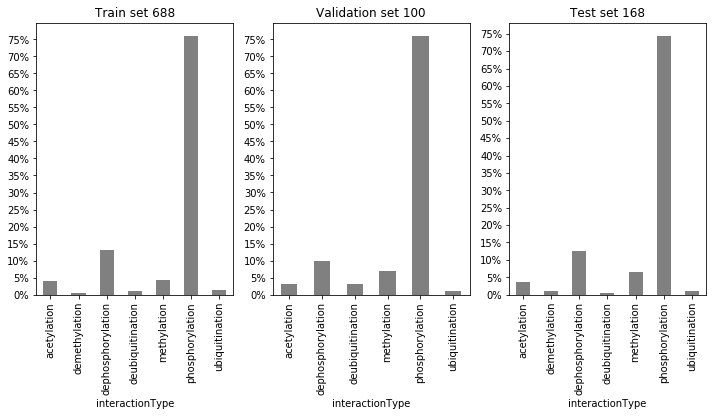

In [62]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,3, figsize=(12,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax[0]
c_ax.set_title('Train set {}'.format(train.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
train.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(train.interactionType))).plot.bar(ax=c_ax, color='gray')




c_ax = ax[1] 
c_ax.set_title('Validation set {}'.format(val.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
val.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(val.interactionType))).plot.bar(ax=c_ax, color='gray')



c_ax = ax[2] 
c_ax.set_title('Test set {}'.format(test.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
test.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(test.interactionType))).plot.bar(ax=c_ax, color='gray')




plt.savefig("split_dataset_postfilter.eps", bbox_inches='tight')
plt.savefig("split_dataset_postfilter.png", bbox_inches='tight')

plt.show()

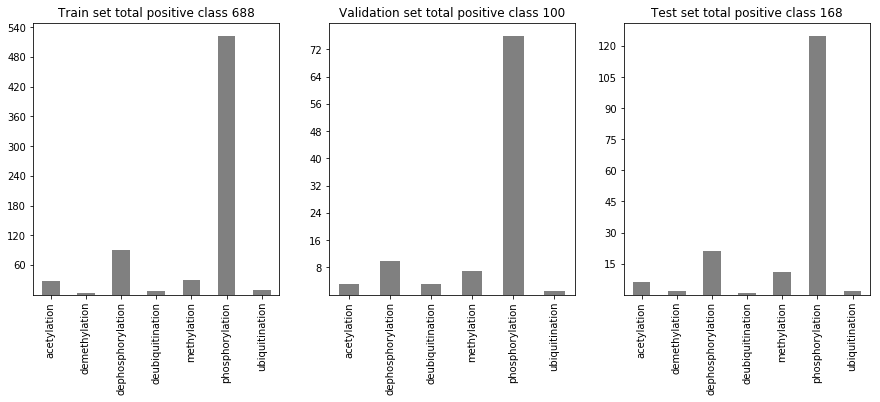

In [63]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,3, figsize=(15,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax[0]
c_ax.set_title('Train set total positive class {}'.format(train.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
train.interactionType.value_counts().sort_index().plot.bar(ax=c_ax, color='gray')




c_ax = ax[1] 
c_ax.set_title('Validation set total positive class {}'.format(val.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
val.interactionType.value_counts().sort_index().plot.bar(ax=c_ax, color='gray')

c_ax = ax[2] 
c_ax.set_title('Test set total positive class {}'.format(test.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
test.interactionType.value_counts().sort_index().plot.bar(ax=c_ax,  color='gray')


plt.savefig('TrainTestValidationInteractionDistribution.eps', bbox_inches='tight')
plt.savefig('TrainTestValidationInteractionDistribution.png', bbox_inches='tight')


plt.show()

### Sample network

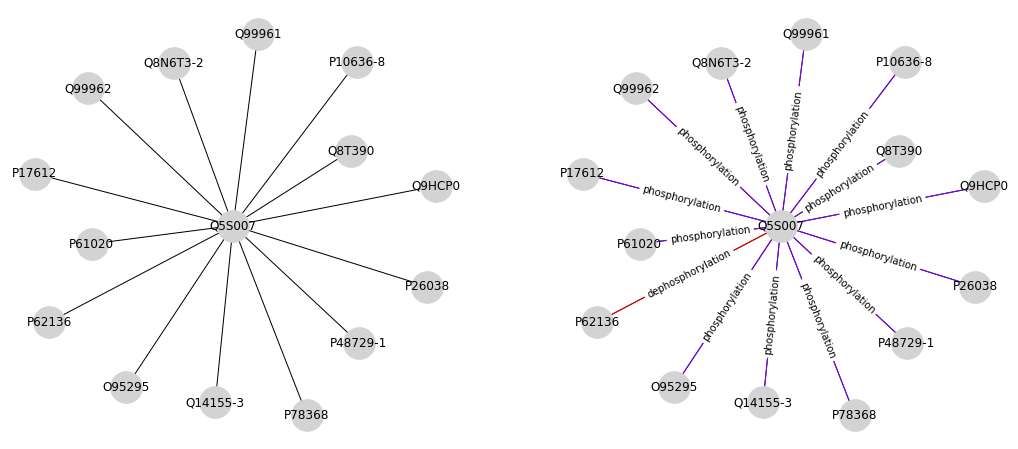

In [64]:
import networkx as nx
import matplotlib.pyplot as plt
import random

random.seed(a=78, version=2)

fig,ax=plt.subplots(1,2, figsize=(18,8))

G=nx.Graph()
# Add nodes and edges
G.add_edges_from(train.query(" participant2Id =='Q5S007' and participant1Id != participant2Id")
                 .apply(lambda x: ( x["participant1Id"],x["participant2Id"], {"type": x['interactionType']}), axis=1))


pos = nx.spring_layout(G,  seed=80)

nx.draw(G, node_color='lightgrey', pos=pos, node_size=1000, with_labels = True, ax=ax[0])


edge_label = nx.get_edge_attributes(G,'type')

colors = {i:random.randint(0, 50) for i in train['interactionType'].unique()}
edge_colors = [ colors[l]  for _,l in edge_label.items()]

cmap=plt.cm.get_cmap("rainbow")
vmin = min(edge_colors)
vmax = max(edge_colors)

nx.draw(G, node_color='lightgrey', pos=pos, node_size=1000, with_labels = True, ax=ax[1])
nx.draw_networkx_edges(G, pos,  width=1.0, edge_color=edge_colors, edge_cmap=cmap, edge_vmin=vmin, edge_vmax=vmax)

nx.draw_networkx_edge_labels(G, pos=pos,alpha=1, edge_labels = nx.get_edge_attributes(G,'type'), ax=ax[1])

plt.savefig('network.pdf', bbox_inches="tight")



plt.show()

### Generate negative samples

In [65]:

# def generate_negative_old(data):
#     import uuid
#     unique_pubmeds = data["pubmedId"].unique()
#     data_fake = pd.DataFrame(columns=data.columns)

#     num_fake_records = int( .50 * len(data))
#     #TODO: Randomise this, biased via
#     for u in unique_pubmeds:
#         fake_records = pd.DataFrame(data[ data.pubmedId != u]  ).sample(n=1) 
#         fake_records.loc[:, "interactionId"] =  fake_records.interactionId.astype(str) + "_" + str(uuid.uuid4() ) + "_" + "fake"
#         fake_records.loc[:,"isValid"] = 'False' 
#         ## Copy of the pubmeid abtract and the title from a id
#         fake_records.loc[:,"pubmedId"] = u
#         fake_records.loc[:, "pubmedTitle"] =  data[ data.pubmedId == u].iloc[0]["pubmedTitle"]
#         fake_records.loc[:, "pubmedabstract"] =  data[ data.pubmedId == u].iloc[0]["pubmedabstract"]


#         data_fake = data_fake.append(fake_records, ignore_index=True)
#         if len(data_fake) > num_fake_records:
#             break
            
#     return data_fake
  
    

In [66]:

def generate_negative_entity(data, enity_annotations_file):
    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader
    from datatransformer.gnormplusNegativeSamplesAugmentor import GnormplusNegativeSamplesAugmentor
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper

    import os
    
 
    localdb = human_idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
            
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))

        negative_samples_generator = GnormplusNegativeSamplesAugmentor(annotations_json, mapper)
        result = negative_samples_generator.transform(data)
        
        

        return result

In [67]:

def generate_negative_interaction(data):

    from datatransformer.interactionTypeNegativeSamplesAugmentor import InteractionTypeNegativeSamplesAugmentor

    import os
    
    negative_samples_generator = InteractionTypeNegativeSamplesAugmentor()
    result = negative_samples_generator.transform(data)


    return result

In [68]:
def generate_negative_missing_participant(data):


    import os
    
    data['isValid'] = data['isValid'].mask( (data['bothParticpantsExist'] == False) & (data['isValid'] == True) , False)


    return data

In [69]:
def plot_negative_distribution(train,val, test, heading, fig, ax  ):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    fig.suptitle(heading)
    #fig, ax = plt.subplots( 7,1, figsize=(45,30))
    c_ax= ax[0]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Training PPI {}".format( train.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    train.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



    c_ax= ax[1]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Validation PPI {}".format(val.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    val.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



    c_ax= ax[2]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Test PPI {}".format(test.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    test.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



   

#### Step1: Add negative entity pairs

In [70]:

train = generate_negative_entity(train, annotations_file)
test = generate_negative_entity(test,  annotations_file)
val = generate_negative_entity(val, annotations_file)



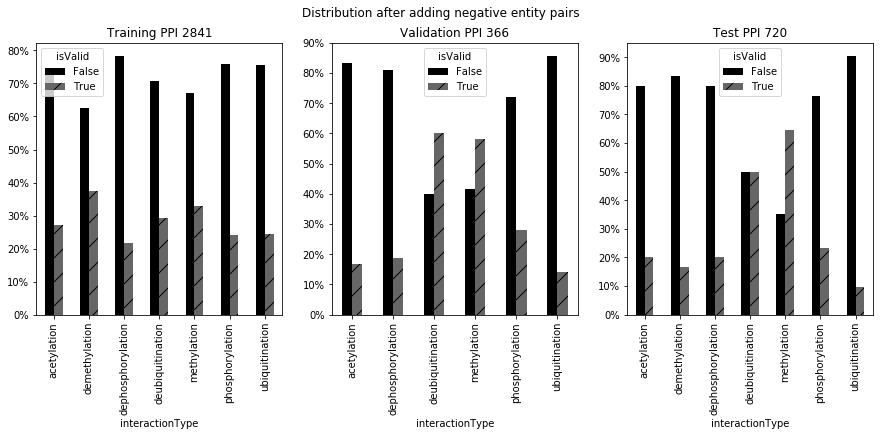

In [71]:
fig, ax = plt.subplots( 1,3, figsize=(15,5))

plt.style.use('grayscale')

plot_negative_distribution(train,  val, test, "Distribution after adding negative entity pairs",fig, ax)
plt.savefig("EntityNegativeSample.eps",bbox_inches = "tight")
plt.savefig("EntityNegativeSample.svg",bbox_inches = "tight")
plt.show()

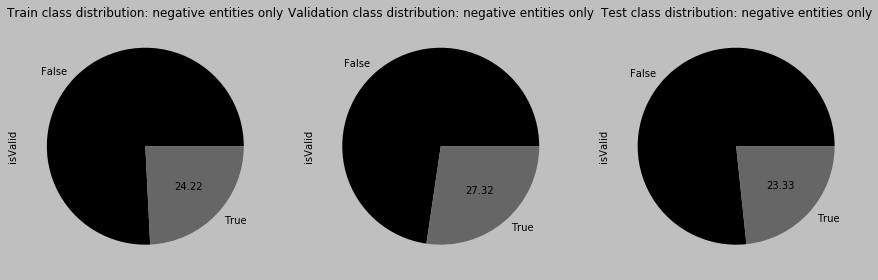

In [72]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,20))

ax[0].set_title('Train class distribution: negative entities only')
train.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution: negative entities only')
val.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])


ax[2].set_title('Test class distribution: negative entities only')
test.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[2])



plt.savefig("PositiveVsNegative_EntityOnly.png")

In [73]:
train.query("pubmedId == '24291004' and isValid==False")[ ["pubmedId","interactionType", "participant1Id", "participant2Id", "pubmedabstract", "normalised_abstract", "annotations", "gene_to_uniprot_map"]]

,pubmedId,interactionType,participant1Id,participant2Id,pubmedabstract,normalised_abstract,annotations,gene_to_uniprot_map
901,24291004,phosphorylation,P31749,P60484,"Glucocorticoid resistance is a major driver of therapeutic failure in T cell acute lymphoblastic leukemia (T-ALL). Here, we identify the AKT1 kinase as a major negative regulator of the NR3C1 glucocorticoid receptor protein activity driving glucocorticoid resistance in T-ALL. Mechanistically, AKT1 impairs glucocorticoid-induced gene expression by direct phosphorylation of NR3C1 at position S134 and blocking glucocorticoid-induced NR3C1 translocation to the nucleus. Moreover, we demonstrate that loss of PTEN and consequent AKT1 activation can effectively block glucocorticoid-induced apoptosis and induce resistance to glucocorticoid therapy. Conversely, pharmacologic inhibition of AKT with MK2206 effectively restores glucocorticoid-induced NR3C1 translocation to the nucleus, increases the response of T-ALL cells to glucocorticoid therapy, and effectively reverses glucocorticoid resistance in vitro and in vivo.","Glucocorticoid resistance is a major driver of therapeutic failure in T cell acute lymphoblastic leukemia (T-ALL). Here, we identify the P31749 kinase as a major negative regulator of the P04150 glucocorticoid receptor protein activity driving glucocorticoid resistance in T-ALL. Mechanistically, P31749 impairs glucocorticoid-induced gene expression by direct phosphorylation of P04150 at position S134 and blocking glucocorticoid-induced P04150 translocation to the nucleus. Moreover, we demonstrate that loss of P60484 and consequent P31749 activation can effectively block glucocorticoid-induced apoptosis and induce resistance to glucocorticoid therapy. Conversely, pharmacologic inhibition of AKT with MK2206 effectively restores glucocorticoid-induced P04150 translocation to the nucleus, increases the response of T-ALL cells to glucocorticoid therapy, and effectively reverses glucocorticoid resistance in vitro and in vivo.","[{'start': '137', 'end': '141', 'name': 'AKT1', 'type': 'Gene', 'normalised_id': '207'}, {'start': '186', 'end': '191', 'name': 'NR3C1', 'type': 'Gene', 'normalised_id': '2908'}, {'start': '294', 'end': '298', 'name': 'AKT1', 'type': 'Gene', 'normalised_id': '207'}, {'start': '375', 'end': '380', 'name': 'NR3C1', 'type': 'Gene', 'normalised_id': '2908'}, {'start': '434', 'end': '439', 'name': 'NR3C1', 'type': 'Gene', 'normalised_id': '2908'}, {'start': '508', 'end': '512', 'name': 'PTEN', 'type': 'Gene', 'normalised_id': '5728'}, {'start': '528', 'end': '532', 'name': 'AKT1', 'type': 'Gene', 'normalised_id': '207'}, {'start': '748', 'end': '753', 'name': 'NR3C1', 'type': 'Gene', 'normalised_id': '2908'}]","{'2908': ['P04150', 'E5KQF5', 'E5KQF6', 'F1D8N4', 'B7Z7I2'], '207': ['P31749', 'B0LPE5', 'B3KVH4'], '5728': ['P60484', 'F6KD01']}"
902,24291004,phosphorylation,P04150,P60484,"Glucocorticoid resistance is a major driver of therapeutic failure in T cell acute lymphoblastic leukemia (T-ALL). Here, we identify the AKT1 kinase as a major negative regulator of the NR3C1 glucocorticoid receptor protein activity driving glucocorticoid resistance in T-ALL. Mechanistically, AKT1 impairs glucocorticoid-induced gene expression by direct phosphorylation of NR3C1 at position S134 and blocking glucocorticoid-induced NR3C1 translocation to the nucleus. Moreover, we demonstrate that loss of PTEN and consequent AKT1 activation can effectively block glucocorticoid-induced apoptosis and induce resistance to glucocorticoid therapy. Conversely, pharmacologic inhibition of AKT with MK2206 effectively restores glucocorticoid-induced NR3C1 translocation to the nucleus, increases the response of T-ALL cells to glucocorticoid therapy, and effectively reverses glucocorticoid resistance in vitro and in vivo.","Glucocorticoid resistance is a major driver of therapeutic failure in T cell acute lymphoblastic leukemia (T-ALL). Here, we identify the P31749 kinase as a ma

In [74]:
train_file ="train_unique_negative_entity_only.json"
train.to_json(train_file)

test_file ="test_unique_negative_entity_only.json"
test.to_json(test_file)

val_file = "val_unique_negative_entity_only.json"
val.to_json(val_file)



In [75]:


from helpers.s3_util import S3Util

S3Util().uploadfile(train_file, "{}/".format( s3_results_prefix.rstrip("/")) )
S3Util().uploadfile(test_file, "{}/".format( s3_results_prefix.rstrip("/")) )
S3Util().uploadfile(val_file, "{}/".format( s3_results_prefix.rstrip("/")) )

Traceback (most recent call last):
  File "/Users/aeg/miniconda/envs/kegg_env/bin/aws", line 19, in <module>
    import awscli.clidriver
  File "/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/awscli/clidriver.py", line 36, in <module>
    from awscli.help import ProviderHelpCommand
  File "/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/awscli/help.py", line 23, in <module>
    from botocore.docs.bcdoc import docevents
ImportError: cannot import name 'docevents' from 'botocore.docs.bcdoc' (/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/botocore/docs/bcdoc/__init__.py)
Traceback (most recent call last):
  File "/Users/aeg/miniconda/envs/kegg_env/bin/aws", line 19, in <module>
    import awscli.clidriver
  File "/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/awscli/clidriver.py", line 36, in <module>
    from awscli.help import ProviderHelpCommand
  File "/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/awscli/h

In [76]:
train.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,73,27
demethylation,5,3
dephosphorylation,326,90
deubiquitination,17,7
methylation,59,29
phosphorylation,1645,523
ubiquitination,28,9


In [77]:
val.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,15,3
dephosphorylation,43,10
deubiquitination,2,3
methylation,5,7
phosphorylation,195,76
ubiquitination,6,1


In [78]:
test.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,24,6
demethylation,10,2
dephosphorylation,83,21
deubiquitination,1,1
methylation,6,11
phosphorylation,409,125
ubiquitination,19,2


In [79]:
pd.DataFrame(train.groupby(['interactionType', 'isValid']).size().unstack())

isValid,False,True
interactionType,,
acetylation,73,27
demethylation,5,3
dephosphorylation,326,90
deubiquitination,17,7
methylation,59,29
phosphorylation,1645,523
ubiquitination,28,9


In [80]:
t = pd.DataFrame(train.groupby(['interactionType', 'isValid']).size().unstack())
t.columns =["False", "True"]

v = pd.DataFrame(val.groupby(['interactionType', 'isValid']).size().unstack())
v.columns = ["False", "True"]

b = pd.DataFrame(test.groupby(['interactionType', 'isValid']).size().unstack())
b.columns = ["False", "True"]

m = t.merge(v, left_index = True, right_index=True, how="left", suffixes=('_train', '_val'))\
       .merge(b, left_index = True, right_index=True, how="left")\

m=m.fillna(0)

m.loc["Total"] = m.apply(lambda x: sum(x))

m["TotalFalse"] =  m.apply(lambda x: sum( [ v for k,v in x.items() if 'false' in k.lower()]), axis=1)
m["TotalTrue"] =  m.apply(lambda x: sum( [ v for k,v in x.items() if 'true' in k.lower()]), axis=1)



print(m.astype('int32').to_latex())
    

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  False\_train &  True\_train &  False\_val &  True\_val &  False &  True &  TotalFalse &  TotalTrue \\
interactionType   &              &             &            &           &        &       &             &            \\
\midrule
acetylation       &           73 &          27 &         15 &         3 &     24 &     6 &         112 &         36 \\
demethylation     &            5 &           3 &          0 &         0 &     10 &     2 &          15 &          5 \\
dephosphorylation &          326 &          90 &         43 &        10 &     83 &    21 &         452 &        121 \\
deubiquitination  &           17 &           7 &          2 &         3 &      1 &     1 &          20 &         11 \\
methylation       &           59 &          29 &          5 &         7 &      6 &    11 &          70 &         47 \\
phosphorylation   &         1645 &         523 &        195 &        76 &    409 &   125 &        2249 &        724 \\
ubiquitination

In [81]:
feature_cols = ["pubmedId","pubmedabstract","annotations", "num_unique_gene_normalised_id", "num_gene_normalised_id", "normalised_abstract", "participant1Id", "participant2Id", "gene_to_uniprot_map"]

derive_class_func = lambda r: r["interactionType"] if r["isValid"] else "other"


In [82]:

train_multiclass = train[ feature_cols]
train_multiclass["class"] = train.apply( derive_class_func, axis=1)

test_multiclass =  test[ feature_cols]
test_multiclass["class"] = test.apply( derive_class_func, axis=1)

val_multiclass =  val[ feature_cols]
val_multiclass["class"] = val.apply( derive_class_func, axis=1)

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [83]:
feature_cols = ["pubmedId","pubmedabstract", "annotations", "num_unique_gene_normalised_id", "num_gene_normalised_id","normalised_abstract", "participant1Id", "participant2Id","gene_to_uniprot_map", "class"]


train_multiclass = train_multiclass[ feature_cols]
test_multiclass = test_multiclass[ feature_cols]
val_multiclass = val_multiclass[ feature_cols]




In [84]:
train_multiclass["class"].value_counts()

other                2153
phosphorylation       523
dephosphorylation      90
methylation            29
acetylation            27
ubiquitination          9
deubiquitination        7
demethylation           3
Name: class, dtype: int64

In [85]:
test_multiclass["class"].value_counts()

other                552
phosphorylation      125
dephosphorylation     21
methylation           11
acetylation            6
ubiquitination         2
demethylation          2
deubiquitination       1
Name: class, dtype: int64

In [86]:
val_multiclass["class"].value_counts()

other                266
phosphorylation       76
dephosphorylation     10
methylation            7
acetylation            3
deubiquitination       3
ubiquitination         1
Name: class, dtype: int64

In [87]:
train_multi_file="train_multiclass.json"
train_multiclass.to_json(train_multi_file)

test_multi_file="test_multiclass.json"
test_multiclass.to_json(test_multi_file)

val_multi_file="val_multiclass.json"
val_multiclass.to_json(val_multi_file)

In [88]:
val_multiclass.head(n=1)

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,participant1Id,participant2Id,gene_to_uniprot_map,class
0,26763134,"Bax-dependent mitochondrial permeabilization during apoptosis is controlled by multiple factors, including the phosphorylation by the protein kinase AKT. We used the heterologous co-expression of human Bax and AKT1 in yeast to investigate how the kinase modulates the different steps underlying Bax activation. We found that AKT activated Bax and increased its cellular content. Both effects were dependent on Ser184, but a phosphorylation of this residue did not fully explain the effects of AKT. Additional experiments with mutants substituted on Ser184 suggested that the regulation of Bax dynamic equilibrium between the cytosol and mitochondria might be more tightly regulated by Bcl-xL when Bax is phosphorylated.","[{'start': '0', 'end': '3', 'name': 'Bax', 'type': 'Gene', 'normalised_id': '581'}, {'start': '149', 'end': '152', 'name': 'AKT', 'type': 'Gene', 'normalised_id': '207'}, {'start': '196', 'end': '201', 'name': 'human', 'type': 'Species', 'normalised_id': '9606'}, {'start': '202', 'end': '205', 'name': 'Bax', 'type': 'Gene', 'normalised_id': '581'}, {'start': '210', 'end': '214', 'name': 'AKT1', 'type': 'Gene', 'normalised_id': '207'}, {'start': '218', 'end': '223', 'name': 'yeast', 'type': 'Species', 'normalised_id': '4932'}, {'start': '295', 'end': '298', 'name': 'Bax', 'type': 'Gene', 'normalised_id': '581'}, {'start': '325', 'end': '328', 'name': 'AKT', 'type': 'Gene', 'normalised_id': '207'}, {'start': '339', 'end': '342', 'name': 'Bax', 'type': 'Gene', 'normalised_id': '581'}, {'start': '493', 'end': '496', 'name': 'AKT', 'type': 'Gene', 'normalised_id': '207'}, {'start': '589', 'end': '592', 'name': 'Bax', 'type': 'Gene', 'normalised_id': '581'}, {'start': '685', 'end': '691', 'name': 'Bcl-xL', 'type': 'Gene', 'normalised_id': '598'}, {'start': '697', 'end': '700', 'name': 'Bax', 'type': 'Gene', 'normalised_id': '581'}]",3,11,"Q07812-dependent mitochondrial permeabilization during apoptosis is controlled by multiple factors, including the phosphorylation by the protein kinase P31749. We used the heterologous co-expression of human Q07812 and P31749 in yeast to investigate how the kinase modulates the different steps underlying Q07812 activation. We found that P31749 activated Q07812 and increased its cellular content. Both effects were dependent on Ser184, but a phosphorylation of this residue did not fully explain the effects of P31749. Additional experiments with mutants substituted on Ser184 suggested that the regulation of Q07812 dynamic equilibrium between the cytosol and mitochondria might be more tightly regulated by Q07817 when Q07812 is phosphorylated.",P31749,Q07817,"{'598': ['Q07817', 'Q5TE63', 'A0A0S2Z3C5'], '207': ['P31749', 'B0LPE5', 'B3KVH4'], '581': ['Q07812', 'I6LPK7', 'Q5ZPJ1', 'Q5ZPJ0']}",other


In [89]:
from helpers.s3_util import S3Util

S3Util().uploadfile(val_multi_file, "{}/".format( s3_results_prefix.rstrip("/")) )
S3Util().uploadfile(test_multi_file, "{}/".format( s3_results_prefix.rstrip("/")) )
S3Util().uploadfile(train_multi_file, "{}/".format( s3_results_prefix.rstrip("/")) )

2021-01-02 21:03:31,382 - helpers.s3_util - INFO - Uploading file val_multiclass.json s3://aegovan-data/processed_dataset/val_multiclass.json
2021-01-02 21:03:42,094 - helpers.s3_util - INFO - Uploading file test_multiclass.json s3://aegovan-data/processed_dataset/test_multiclass.json
2021-01-02 21:03:52,508 - helpers.s3_util - INFO - Uploading file train_multiclass.json s3://aegovan-data/processed_dataset/train_multiclass.json


In [90]:
train_multiclass.sample(n=50).to_json("sample_train_multiclass.json")

#### Step 2: Add negative interaction types

In [91]:

# train = generate_negative_interaction(train)
# test = generate_negative_interaction(test)
# val = generate_negative_interaction(val)


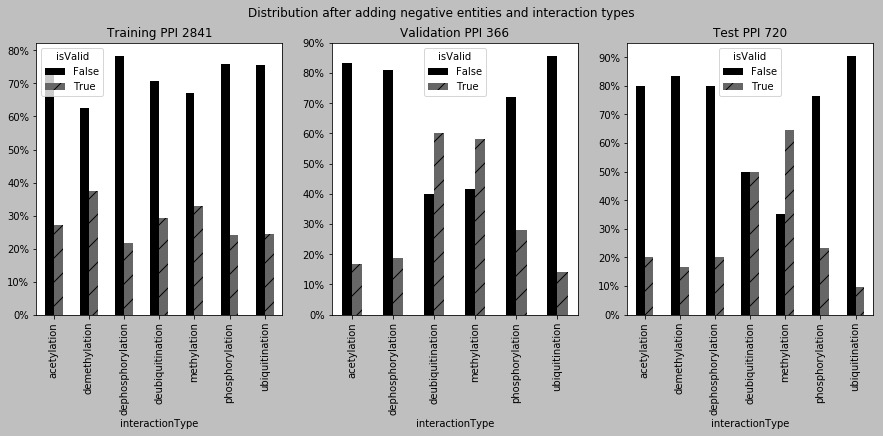

In [92]:

fig, ax = plt.subplots( 1,3, figsize=(15,5))

plot_negative_distribution(train,  val, test, "Distribution after adding negative entities and interaction types",fig, ax)
plt.savefig("EntityInteractionNegativeSample.png",bbox_inches = "tight")
plt.savefig("EntityInteractionNegativeSample.svg",bbox_inches = "tight")
plt.show()

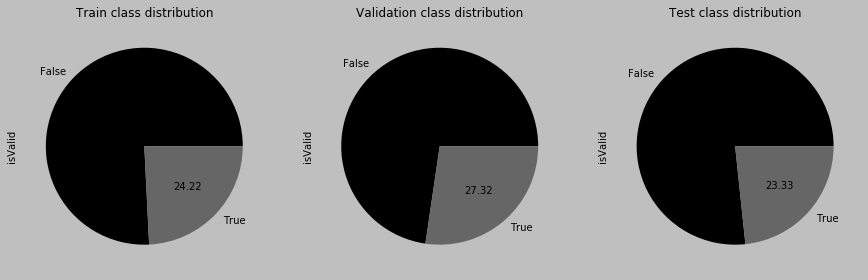

In [93]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,20))

ax[0].set_title('Train class distribution')
train.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution')
val.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])


ax[2].set_title('Test class distribution')
test.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[2])



plt.savefig("Interaction.png")

In [94]:
train.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,73,27
demethylation,5,3
dephosphorylation,326,90
deubiquitination,17,7
methylation,59,29
phosphorylation,1645,523
ubiquitination,28,9


In [95]:
test.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,24,6
demethylation,10,2
dephosphorylation,83,21
deubiquitination,1,1
methylation,6,11
phosphorylation,409,125
ubiquitination,19,2


In [96]:
val.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,15,3
dephosphorylation,43,10
deubiquitination,2,3
methylation,5,7
phosphorylation,195,76
ubiquitination,6,1


In [97]:
test.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,24,6
demethylation,10,2
dephosphorylation,83,21
deubiquitination,1,1
methylation,6,11
phosphorylation,409,125
ubiquitination,19,2


In [98]:
val.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,15,3
dephosphorylation,43,10
deubiquitination,2,3
methylation,5,7
phosphorylation,195,76
ubiquitination,6,1


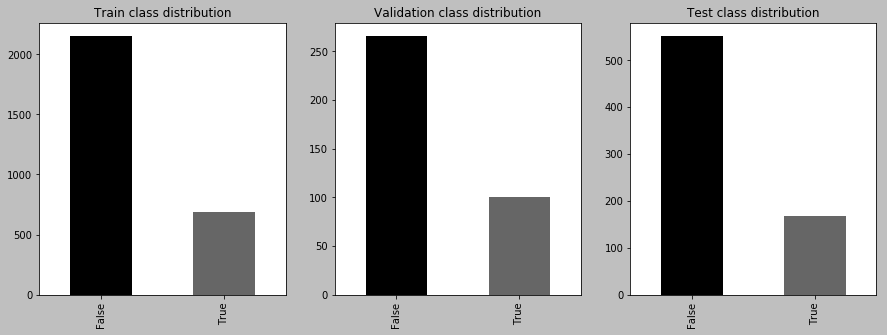

In [99]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].set_title('Train class distribution')
train.isValid.value_counts().plot.bar( ax=ax[0])

ax[1].set_title('Validation class distribution')
val.isValid.value_counts().plot.bar( ax=ax[1])


ax[2].set_title('Test class distribution')
test.isValid.value_counts().plot.bar( ax=ax[2])



plt.savefig("Interaction.png")

In [100]:
train.to_json("train_unique_pub_v6_max_neg.json")
test.to_json("test_unique_pub_v6_max_neg.json")
val.to_json("val_unique_pub_v6_max_neg.json")

In [101]:
train.sample(n=20).to_json("sample_train.json")

In [102]:
train.query('isValid == True').sample(n=3)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,gene_to_uniprot_map,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist
2234,6,True,512481,phosphorylation,True,True,"[[stk3_human], [Serine/threonine-protein kinase 3], [STE20-like kinase MST2], [Mammalian STE20-like protein kinase 2], [Serine/threonine-protein kinase Krs-1], [STK3], [MST2], [KRS1]]",Q13188,"[[sav1_human], [Protein salvador homolog 1], [SAV1], [WW45], [45 kDa WW domain protein]]",Q9H4B6,2,16930133,None,"Genetic screens in Drosophila have revealed that the serine/threonine kinase Hippo (Hpo) and the scaffold protein Salvador participate in a pathway that controls cell proliferation and apoptosis. Hpo most closely resembles the pro-apoptotic mammalian sterile20 kinases 1 and 2 (Mst1 and 2), and Salvador (Sav) has a human orthologue hSav (also called hWW45). Here we show that Mst and hSav heterodimerize in an interaction requiring the conserved C-terminal coiled-coil domains of both proteins. hSav was also able to homodimerize, but this did not require its coiled-coil domain. Coexpression of Mst and hSav led to phosphorylation of hSav and also increased its abundance. In vitro phosphorylation experiments indicate that the phosphorylation of Sav by Mst is direct. The stabilizing effect of Mst was much greater on N-terminally truncated hSav mutants, as long as they retained the ability to bind Mst. Mst mutants that lacked the C-terminal coiled-coil domain and were unable to bind to hSav, also failed to stabilize or phosphorylate hSav, whereas catalytically inactive Mst mutants that retained the ability to bind to hSav were still able to increase its abundance, although they were no longer able to phosphorylate hSav. Together these results show that hSav can bind to, and be phosphorylated by, Mst, and that the stabilizing effect of Mst on hSav requires its interaction with hSav but is probably not due to phosphorylation of hSav by Mst.","Genetic screens in Drosophila have revealed that the serine/threonine kinase Hippo (Hpo) and the scaffold protein Salvador participate in a pathway that controls cell proliferation and apoptosis. Hpo most closely resembles the pro-apoptotic mammalian sterile20 kinases 1 and 2 (4485;6788), and Salvador (Q9H4B6) has a human orthologue Q9H4B6 (also called Q9H4B6). Here we show that Mst and Q9H4B6 heterodimerize in an interaction requiring the conserved C-terminal coiled-coil domains of both proteins. Q9H4B6 was also able to homodimerize, but this did not require its coiled-coil domain. Coexpression of Mst and Q9H4B6 led to phosphorylation of Q9H4B6 and also increased its abundance. In vitro phosphorylation experiments indicate that the phosphorylation of Q9H4B6 by Mst is direct. The stabilizing effect of Mst was much greater on N-terminally truncated Q9H4B6 mutants, as long as they retained the ability to bind Mst. Mst mutants that lacked the C-terminal coiled-coil domain and were unable to bind to Q9H4B6, also failed to stabilize or phosphorylate Q9H4B6, whereas catalytically inactive Mst mutants that retained the ability to bind to Q9H4B6 were still able to increase its abundance, although they were no longer able to phosphorylate Q9H4B6. Together these results show that Q9H4B6 can bind to, and be phosphorylated by, Mst, and that the stabilizing effect of Mst on Q9H4B6 requires its interaction with Q9H4B6 but is probably not due to phosphorylation of Q9H4B6 by Mst.","[{'start': '241', 'end': '250', 'name': 'mammalian', 'type': 'Species', 'normalised_id': '9606'}, {'start': '278', 'end': '288', 'name': 'Mst1 and 2', 'type': 'Gene', 'normalised_id': '4485;6788'}, {'start': '305', 'end': '308', 'name': 'Sav', 'type': 'Gene', 'normalised_id': '60485'